Multigrid in FEM, implement the V-cycle using PyAMG package. Using linear interpolation operator for the prolongation in PyAMG.

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MeshFEM():
    """ Handle the square mesh, quad elements
    0: background square; 1: circular region
    
    Parameters:
        size: length of the square plate
        nnode_edge: number of nodes along edges of the plate
    """

    def __init__(self, size = 2, prop = [1,1], nnode_edge = 65, outfile = None):
        self.size = size
        self.nnode_edge = nnode_edge
        self.points, self.cells, self.mesh = None, None, None
        self.node_list = np.arange(nnode_edge*nnode_edge)
        self.generate_mesh()
        self.generate_node_index()
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self):
        x = np.linspace(self.size/2,-self.size/2,self.nnode_edge, dtype=np.float32)
        y = np.linspace(-self.size/2,self.size/2,self.nnode_edge, dtype=np.float32)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float32)
        self.points = np.concatenate((x,y,z),axis=1)
        n_element = (self.nnode_edge-1)*(self.nnode_edge-1)
        nodes = np.linspace(0,self.points.shape[0],self.points.shape[0],endpoint=False,dtype=int).reshape(self.nnode_edge,self.nnode_edge)
        self.cells = np.zeros((n_element,4),dtype=int)
        self.cells[:,0] = np.ravel(nodes[:self.nnode_edge-1,:self.nnode_edge-1])
        self.cells[:,1] = np.ravel(nodes[:self.nnode_edge-1,1:])
        self.cells[:,2] = np.ravel(nodes[1:,1:])
        self.cells[:,3] = np.ravel(nodes[1:,:self.nnode_edge-1])
        self.mesh = meshio.Mesh(self.points, [("quad",self.cells)])

    def generate_node_index(self):
        '''Generate node index matrix that indicate boundary (True) or internal nodes (False)'''
        self.node_index = []
        for pt in self.points:
            if(np.isclose(pt[0],-1) or np.isclose(pt[0],1) or np.isclose(pt[1],-1)  or np.isclose(pt[1],1)):
                self.node_index.append(True)
            else:
                self.node_index.append(False)
        self.node_essential = self.node_list[self.node_index]
        self.node_internal = self.node_list[np.invert(self.node_index)]
    
    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'plate_mesh.vtk'):
        self.mesh.write(outfile)

In [3]:
class GridFEM():
    '''
    Note: the n should be the number of intervals, e.g., 
    there are (n-1)*(n-1) internal grid points 
    '''
    def __init__(self, n, size = 2):
        self.size = size
        self.n = n 
        self.omega = 2/3
        self.property = [1, 1] # homogeneous problem
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4]
        self.v = np.zeros((n-1)*(n-1))
        self.f = np.zeros((n-1)*(n-1))
        self.grid = MeshFEM(size, prop=self.property, nnode_edge=n+1)
        self.A, self.A_EF = self.CreateA()

    def IsCoarsest(self):
        return self.n == 2
        
    def CreateA(self):
        '''
        Stiffness matrix 
        ''' 
        A = np.zeros(((self.n+1)*(self.n+1),(self.n+1)*(self.n+1)))
        for c in self.grid.cells:
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            D = np.eye(2)
            Ke = np.zeros((4,4))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((2,4))
                B[0,:] = dNdx[:,0]
                B[1,:] = dNdx[:,1]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            A[np.ix_(c,c)] += Ke
            
        return A[np.ix_(self.grid.node_internal,self.grid.node_internal)], A[np.ix_(self.grid.node_essential,self.grid.node_internal)]

    def UpdateRHS(self, f):
        '''
        Return the internal part of rhs sourcing term with modification from finite element term
        '''
        ff = np.zeros((self.n+1)*(self.n+1))
        f_temp = np.zeros((self.n+1)*(self.n+1))
        f_temp[self.grid.node_internal] = f
        for c in self.grid.cells:
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            fe = np.zeros(4)
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                temp = np.linalg.det(J)*np.dot(N,np.dot(N.T,f_temp[c])) #[4x1]
                fe += temp
            ff[c] += fe
        return ff[self.grid.node_internal]

    def Relax(self, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iterations for current level of grid
        '''
        Dinv = np.diag(1.0/np.diag(self.A))
        v = self.v
        for i in range(num_sweeps_down):
            vprev = v
            residual = self.f - np.dot(self.A,vprev)
            v = self.omega*np.dot(Dinv,residual) + vprev
        return v

In [4]:
class ManufacturedPoisson():
    '''
    Define the manufactured 2D Poisson problem 
    '''
    def __init__(self, n = 64):

        # Problem parameters
        C = 5.0
        k = 1
        l = 2

        self.n = n # total number of grids for finest grid
        self.solution = []
        self.grid = GridFEM(self.n)

        internal_pts = self.grid.grid.points[self.grid.grid.node_internal,:] # internal node coordinates of finest grid
        sourcing_term = C*np.sin(k*np.pi*internal_pts[:,0])*np.sin(l*np.pi*internal_pts[:,1])
        self.u_exact = C/(np.power(np.pi*k,2)+np.power(np.pi*l,2))*np.sin(k*np.pi*internal_pts[:,0])*np.sin(l*np.pi*internal_pts[:,1])  # exact solution

        ff = self.grid.UpdateRHS(sourcing_term)
        
        # we can do following because essential bc is zero
        self.grid.f = ff # assign the finest right hand side with the original rhs

    def Error(self,v):
        '''
        Compute the error between current approximation and exact solution
        v should be a 1D vector
        '''
        return np.linalg.norm(v-self.u_exact.reshape(-1), ord=np.inf)
    
    def plot(self):
        '''Plot the solution vector v in 2D'''
        self.solution = self.grid.v
        uu = self.solution.reshape(self.xx.shape)
        fig = plt.figure()
        plt.contourf(self.x,self.y,uu)
        plt.axis('scaled')
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.colorbar()


In [5]:
n = 64
prob = ManufacturedPoisson(n)

In [6]:
# Weighted Jacobi iteration
EPS = 1e-6
n_jacobi = 0
u_jacobi = np.zeros((n-1)*(n-1))
e_jacobi = 1
e_relative_jacobi = [e_jacobi]
while (e_jacobi>EPS):
    u_prev = u_jacobi
    prob.grid.v = u_jacobi
    u_jacobi = prob.grid.Relax(1)
    e_jacobi = np.sqrt(np.sum((u_jacobi - u_prev) ** 2)) / np.sqrt(np.sum((u_jacobi) ** 2))
    e_relative_jacobi.append(e_jacobi)
    print(e_jacobi)
    n_jacobi += 1

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

1.0
0.49698590051046143
0.3293226579694888
0.24549712922284664
0.19520668549804016
0.16168378375290732
0.1377423340111427
0.11978929119618767
0.10582851907586865
0.09466233584025946
0.08552858027344395
0.07791914483940307
0.07148226272826763
0.06596667188275336
0.061188113414027065
0.05700839311162725
0.053321833008711225
0.050046239092223936
0.04711672131512229
0.044481367604935894
0.042098153869885316
0.039932696730607495
0.03795659249578214
0.03614617139385428
0.034481550789146345
0.03294590688656237
0.031524908279693814
0.03020627088147672
0.02897940493816335
0.027835132640501963
0.026765460390819337
0.025763393770027503
0.02482278614699489
0.02393821400391273
0.02310487363445775
0.022318495058929477
0.021575269899096874
0.020871790641228724
0.02020499924327483
0.019572143450971663
0.018970739506714535
0.018398540185735293
0.01785350729234964
0.0173337879067176
0.01683769379870393
0.01636368352688852
0.015910346822810756
0.015476390927184568
0.015060628599231211
0.01466196756489327

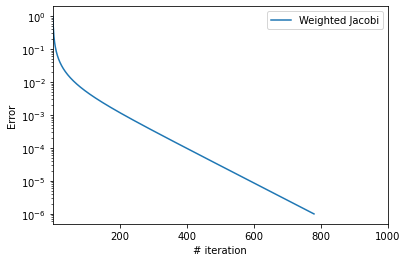

In [7]:
# Plot the relative error
plt.plot(e_relative_jacobi, label='Weighted Jacobi')
#plt.xscale('log')
plt.yscale('log')
plt.xlim([1,1000])
plt.xlabel('# iteration')
plt.ylabel('Error')
plt.legend()

In [15]:
# Solve the problem using PyAMG
import pyamg
from scipy.sparse import csr_matrix

A_sparse = csr_matrix(prob.grid.A) # Convert the stiffness matrix to sparse matrix (CSR method)
b = prob.grid.f

ml = pyamg.smoothed_aggregation_solver(A_sparse) # Setup the grid hierarchy using blackbox multigrid
print(ml)                                 # print hierarchy information

print("The Multigrid Hierarchy")
print("-----------------------")
for l in range(len(ml.levels)):
    An = ml.levels[l].A.shape[0]
    Am = ml.levels[l].A.shape[1]
    if l == (len(ml.levels)-1):
        print(f"A_{l}: {An:>10}x{Am:<10}")
    else:
        Pn = ml.levels[l].P.shape[0]
        Pm = ml.levels[l].P.shape[1]
        print(f"A_{l}: {An:>10}x{Am:<10}   P_{l}: {Pn:>10}x{Pm:<10}")
        
res1 = []
x = ml.solve(b, tol=1e-12, residuals=res1) # Solve the problem

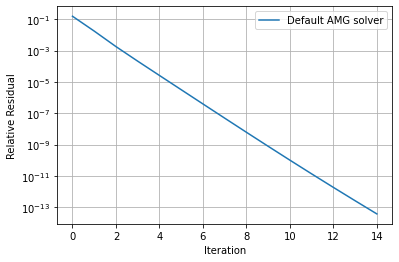

In [20]:
fig, ax = plt.subplots()
ax.semilogy(res1, label='Default AMG solver')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Residual')
ax.grid(True)
plt.legend()